<div style="background:#FFFFEE; color:#440404; padding:8px; border-radius: 4px; text-align: center; font-weight: 500;">This project is part of the Data Analytics for Strategic Decision Makers unit</div>

The Advance Queensland program aims to foster innovation and economic growth across various sectors, including healthcare, in Queensland. Understanding how these advancements are covered in the media provides valuable insights into public perception and the effectiveness of the program. The Guardian, a reputable news outlet, offers comprehensive coverage of various sectors, making it an ideal source for analysis. By examining the prevalent themes in The Guardian's articles, it is possible to identify the key areas of focus, recurring issues, and the impact of these advancements on the community. This understanding can help policymakers, researchers, and the public to gauge the success of the program and identify areas needing further attention. Consequently, the exploration of these themes and their coverage leads to the question: 

**What are the prevalent themes in The Guardian's articles about healthcare advancements driven by the Advance Queensland program?**

---


### Data Collection

In [2]:
# Install necessary packages
!pip install nltk pyarrow
!pip install nltk

# Import libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import random
import requests
import json
import re
import time
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
# Load my personal API key
with open('guardian_key.txt', 'r') as file:
    key = file.read().strip()

In [4]:
# Build a search URL
base_url = 'https://content.guardianapis.com/'
search_string = 'Queensland%20AND%20(health*%20OR%20medical%20OR%20medicare%20OR%20%22public%20health%22)%20AND%20(funding%20OR%20budget%20OR%20innovation)%20AND%20NOT%20(NSW%20OR%20Victoria%20OR%20Victorian)'
production_office = 'aus'
from_date = '2019-01-01'

full_url = base_url+f"search?q={search_string}&production-office={production_office}&from-date={from_date}&show-fields=body&api-key={key}"

print(full_url[:300])

https://content.guardianapis.com/search?q=Queensland%20AND%20(health*%20OR%20medical%20OR%20medicare%20OR%20%22public%20health%22)%20AND%20(funding%20OR%20budget%20OR%20innovation)%20AND%20NOT%20(NSW%20OR%20Victoria%20OR%20Victorian)&production-office=aus&from-date=2019-01-01&show-fields=body&api-ke


#### Search Criteria

To ensure a focused and relevant dataset, specific search criteria were established. These criteria were designed to capture articles related to healthcare advancements in Queensland while excluding unrelated regions and terms.

*Queensland AND (health\*, medical, medicare, "public health") AND (funding, budget, innovation) AND NOT (NSW OR Victoria OR Victorian)*

- **Primary Focus**: Queensland AND (health*, medical, medicare, "public health")

  By including terms like health*, medical, medicare, and "public health," the search captures a broad spectrum of healthcare-related topics.
  The use of the asterisk * after "health" allows for the inclusion of any word that starts with "health" to ensure that the query captures all possible terms related to health.
- **Specific Aspects**: funding, budget, innovation

  Terms such as funding, budget, and innovation are included because they align with the core objectives of the Advance Queensland program, which aims to drive innovation and economic growth through strategic investments in several sectors, including healthcare.
- **Exclusions**: NSW, Victoria, Victorian

  The exclusion of terms related to NSW, Victoria, and Victorian helps refine the search, eliminating articles that may discuss healthcare advancements in other regions.
- **Production Office**: aus (Australia)
- **Date Range**: From 1 January 2019 to the present.

  In addition to capturing recent and relevant articles, this time frame is particularly significant because the first whole-of-initiative evaluation of Advance Queensland, assessing the implementation and achievements of the first three years (July 2015 to June 2018), was completed by Deloitte Access Economics in 2019. This evaluation provides a baseline for measuring subsequent progress and innovations, making articles published from 2019 onwards crucial for understanding the program's ongoing impact.

In [5]:
# Get data from server
server_response = requests.get(full_url)
server_data = server_response.json()
resp_data = server_data.get('response', '')

if resp_data == '':
    print("ERROR obtaining results:", server_data)
else:
    print("SUCCESS!")
    print(f"{resp_data['total']} results found available in {resp_data['pages']} pages")
    print(f"{resp_data['pageSize']} results per page")
    results = resp_data.get('results', [])

for result in results:
    result_id = result.get('id')

SUCCESS!
114 results found available in 12 pages
10 results per page


The search yielded 114 results across 12 pages, indicating a substantial volume of articles relevant to the research topic. 

In [6]:
def articles_from_page_results(page_results):
    articles = {}
    for result in page_results:
        article_date = result['webPublicationDate']
        article_title = result['webTitle'] + f" [{article_date}]"
        article_html = result['fields']['body']
        article_text = re.sub(r'<.*?>', '', article_html)
        articles[article_title] = article_text
    return articles

def get_all_articles_for_response(response_json, full_url):
    total_pages = response_json['pages']
    total_articles = response_json['total']
    print(f"Fetching {total_articles} articles from {total_pages} pages...")
    all_articles = {}
    page1_articles = articles_from_page_results(response_json['results'])
    all_articles.update(page1_articles)
    print("Added articles for page: 1")
    
    for page in range(2, total_pages + 1):
        print("Getting articles from API for page:", page)
        page_response = requests.get(full_url + f"&page={page}")
        page_data = page_response.json()['response']
        print("Processing results for page:", page_data['currentPage'])
        page_articles = articles_from_page_results(page_data['results'])
        print(f"Fetched {len(page_articles)} articles.")
        all_articles.update(page_articles)
        print("Added articles for page:", page)
        print(f"Status: {len(all_articles)} articles.")
        time.sleep(1)  # Make sure we're not hitting the API too hard
    
    print(f"FINISHED: Fetched {len(all_articles)} articles.")
    return all_articles

In [7]:
my_articles = get_all_articles_for_response(resp_data, full_url)

Fetching 114 articles from 12 pages...
Added articles for page: 1
Getting articles from API for page: 2
Processing results for page: 2
Fetched 10 articles.
Added articles for page: 2
Status: 20 articles.
Getting articles from API for page: 3
Processing results for page: 3
Fetched 10 articles.
Added articles for page: 3
Status: 30 articles.
Getting articles from API for page: 4
Processing results for page: 4
Fetched 10 articles.
Added articles for page: 4
Status: 40 articles.
Getting articles from API for page: 5
Processing results for page: 5
Fetched 10 articles.
Added articles for page: 5
Status: 50 articles.
Getting articles from API for page: 6
Processing results for page: 6
Fetched 10 articles.
Added articles for page: 6
Status: 60 articles.
Getting articles from API for page: 7
Processing results for page: 7
Fetched 10 articles.
Added articles for page: 7
Status: 70 articles.
Getting articles from API for page: 8
Processing results for page: 8
Fetched 10 articles.
Added articles f

**The following list comprises the titles of all articles retrieved from The Guardian's API:**

In [8]:
print("Total Articles:",len(my_articles))
for title,text in my_articles.items():
    print(title)

Total Articles: 114
Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z]
From rural medicine to tech innovations: two trailblazers channel their studies into what matters  [2023-11-20T03:21:35Z]
Morning Mail: PM reveals green industry strategy; Biden ‘considering’ dropping Assange charges; Queensland conspiracy theories [2024-04-10T20:51:13Z]
Queensland state budget 2023 winners and losers: parents, households prioritised over coal lobby’s campaign [2023-06-13T04:02:50Z]
Schools funding and reforms panel: five key takeaways [2023-12-11T14:00:38Z]
Queensland health boss resigns amid criticism of proposed whistleblower law change [2023-06-28T03:37:37Z]
Queensland Labor’s lurch to the right on youth justice shows a government that’s lost principles and perspective  [2024-05-01T05:14:02Z]
Queensland budget 2023: coal royalty boom funds $550 energy rebate, free kindergarten and a record surplus [2023-06-13T05:33:36Z]
Queensland man who died after sna

In [9]:
# Save the articles to a JSON file
file_name = "AQ-healthcare-articles.json"

with open(file_name, 'w', encoding='utf-8') as fp:
    json.dump(my_articles, fp)

Saving the raw articles fetched from the API to a JSON file is crucial for preserving the original data. This ensures that there is a backup of the unprocessed data.

### Data Preprocessing

Text preprocessing is a crucial step in text analysis. This step is essential to ensure that the text data is consistent and free from noise, such as irrelevant characters or formatting issues, which can adversely affect the performance of text mining and machine learning algorithms. Effective preprocessing enhances the accuracy and efficiency of subsequent analysis by reducing complexity and focusing on meaningful patterns within the data.

Text preprocessing also has ethical implications. Careful preprocessing can help mitigate biases present in the data, leading to fairer and more equitable analysis outcomes.

In [10]:
# Load the articles from the JSON file
with open(file_name, 'r', encoding='utf-8') as fp:
    articles = json.load(fp)

print(f"Loaded {len(articles)} articles from {file_name}")

Loaded 114 articles from AQ-healthcare-articles.json


In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace abbreviations
    text = text.replace("bn", "billion")
    text = text.replace('&nbsp;', ' ')
    # Remove special characters and normalise whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    # Tokenization
    word_tokens = word_tokenize(text)
    # Lower casing
    word_tokens = [word.lower() for word in word_tokens]
    # Removal of numbers and punctuation
    word_tokens = [re.sub(r'\d+|\d*\.\d+', '', word) for word in word_tokens]
    punctuation_table = str.maketrans('', '', string.punctuation)
    word_tokens = [word.translate(punctuation_table) for word in word_tokens]
    word_tokens = [word for word in word_tokens if word]  # Remove empty strings
    # Removal of stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['gmt', 'bst'])  # Add 'gmt' and 'bst' to the stop words set
    word_tokens = [word for word in word_tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens]
    # Convert the list of tokenized words back to a string
    processed_text = ' '.join(word_tokens)
    return processed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/n11734264/ifn619/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/n11734264/ifn619/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/n11734264/ifn619/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The following preprocessing steps are implemented in the code:

1. **Removing HTML tags** cleans the text of any formatting artifacts that might interfere with analysis. This ensures that the content is purely textual and free from HTML elements.
2. **Replacing abbreviations** It was noticed that "bn" is frequently used as an abbreviation for "billion" in the articles. Replacing abbreviations like "bn" with "billion" ensures that the text's meaning is clear. Additionally, replacing "nbsp" (a non-breaking space character used in HTML) with a blank space (' ') helps to clean the text and make it interpretable by the subsequent processing steps.
3. **Eliminating special characters and normalising whitespace** helps to simplify the text by removing any extraneous symbols that do not contribute to the content's meaning. 
4. **Tokenization** allows for more granular text analysis. This is a fundamental step in preparing the text for further processing.
5. **Lowercasing the text** ensures that words are treated uniformly, regardless of their original case. 
6. **Removing numbers and punctuation** further refines the text, ensuring that only meaningful words are kept. This helps in focusing on the core content of the text.
7. **Filtering Out Stopwords** removes common words that add little value to the analysis. Terms like "gmt" and "bst" are time zone references that do not provide meaningful information about healthcare advancements or related topics. Including these terms in the stopwords set ensures they are removed during preprocessing.
8. **Lemmatization** reduces words to their base forms, ensuring that different variations of a word are treated as a single item. This reduces dimensionality and improves the quality of text analysis.

By following these preprocessing steps, the text is transformed into a clean and standardised format that is ready for more effective and accurate analysis. 

**REMARK:** The preprocessing steps were referenced from Ayse Laydin's article on text preprocessing techniques https://ayselaydin.medium.com/1-text-preprocessing-techniques-for-nlp-37544483c007, and the usage of lemmatization was guided by GeeksforGeeks' article on Python lemmatization with NLTK https://www.geeksforgeeks.org/python-lemmatization-with-nltk/.

In [12]:
# Function to preprocess all articles
def preprocess_articles(articles):
    processed_articles = {}
    for title, text in articles.items():
        processed_text = preprocess_text(text)
        processed_articles[title] = processed_text
    return processed_articles

processed_articles = preprocess_articles(my_articles)

# Print processed articles for inspection
for title, processed_text in processed_articles.items():
    print(f"Title: {title}")
    # Split the processed text into words and print the first 50 words
    words = processed_text.split()[:50]
    print(f"Processed Text: {' '.join(words)}...")
    print("\n")

Title: Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z]
Processed Text: may treasurer jim chalmers deliver second full year budget chalmers promised cost living relief budget say tackle inflation set australia economy growth neither scorched earth free spending know already budget tax cut cost living biggest element cost living relief budget change stage three tax cut billion year tax cut package...


Title: From rural medicine to tech innovations: two trailblazers channel their studies into what matters  [2023-11-20T03:21:35Z]
Processed Text: named forbes list asia last year mikaela seymour achieved much since graduating griffith university seymour studied bachelor medical science queensland based university four year postgraduate doctor medicine md completed decided rewarding path would pursue rural remote medicine completed rotation tropical medicine organised school medicine dentistry partnership rural medical education australia...


Ti

Preprocessing articles and printing a sample of the processed text ensures the effectiveness of the preprocessing steps. This verification step confirms that HTML tags, special characters, stopwords, and other undesired elements are correctly removed. According to the inspection, it is confirmed that the preprocessing function works as intended, resulting in text that is cleaned and standardised, and ready for further analysis.

### Find Articles Closely Related to the Keyword Using Cosine Similarity
The first step in theme extraction is to identify articles closely related to the keyword "Advance Queensland healthcare advancements" using cosine similarity. By calculating the cosine similarity between the TF-IDF vector representation of the keyword and each article in the dataset, the documents that are most similar in content can be retrieved. This approach ensures no content directly related to the keyword is overlooked, and provides a strong foundation for further thematic analysis.

In [13]:
import matplotlib.pyplot as plt

# Create Document-Term Matrix using TF-IDF
# max_df=0.75: Ignore terms that appear in more than 75% of the documents
# min_df=2: Ignore terms that appear in fewer than 2 documents
# max_features=10000: Only consider the top 10,000 terms by TF-IDF score
# stop_words='english': Remove common English stop words

tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, max_features=10000, stop_words='english')

# Fit the TF-IDF vectorizer to the corpus and transform the corpus into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_articles.values())

# Get the feature names (terms) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to recommend documents based on a keyword
def recommend_documents(keyword, tfidf_matrix, tfidf_vectorizer, processed_articles, top_n=5):
    keyword_vector = tfidf_vectorizer.transform([keyword])
    cosine_similarities = cosine_similarity(keyword_vector, tfidf_matrix).flatten()
    related_docs_indices = cosine_similarities.argsort()[:-top_n-1:-1]
    
    recommended_docs = []
    for index in related_docs_indices:
        doc_title = list(processed_articles.keys())[index]
        similarity_score = cosine_similarities[index]
        recommended_docs.append((doc_title, similarity_score))
    
    # Visualization
    doc_titles = [doc[0] for doc in recommended_docs]
    similarity_scores = [doc[1] for doc in recommended_docs]
    
    plt.figure(figsize=(12, 7))
    plt.barh(doc_titles, similarity_scores, color='darkkhaki')
    plt.xlabel('Similarity Score')
    plt.title(f'Top Documents for Keyword: {keyword}')
    plt.gca().invert_yaxis()  # Invert y-axis to have highest similarity at the top
    plt.show()
    
    return recommended_docs

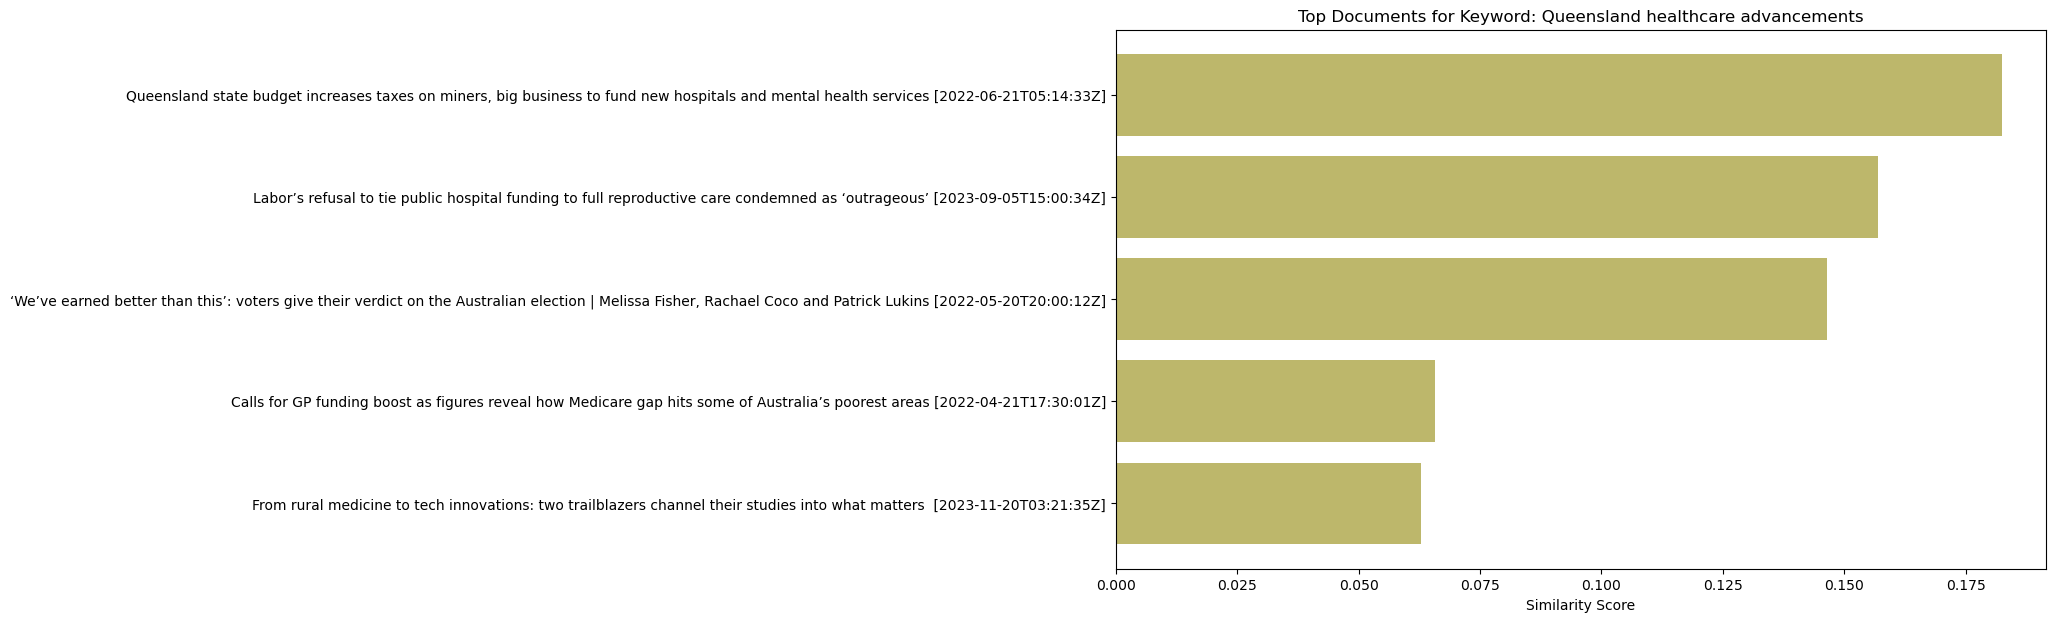

Top documents for keyword 'Queensland healthcare advancements':

Title: Queensland state budget increases taxes on miners, big business to fund new hospitals and mental health services [2022-06-21T05:14:33Z], Similarity Score: 0.1824

Title: Labor’s refusal to tie public hospital funding to full reproductive care condemned as ‘outrageous’ [2023-09-05T15:00:34Z], Similarity Score: 0.1569

Title: ‘We’ve earned better than this’: voters give their verdict on the Australian election | Melissa Fisher, Rachael Coco and Patrick Lukins [2022-05-20T20:00:12Z], Similarity Score: 0.1463

Title: Calls for GP funding boost as figures reveal how Medicare gap hits some of Australia’s poorest areas [2022-04-21T17:30:01Z], Similarity Score: 0.0657

Title: From rural medicine to tech innovations: two trailblazers channel their studies into what matters  [2023-11-20T03:21:35Z], Similarity Score: 0.0628


In [14]:
keyword = "Queensland healthcare advancements"
recommended_docs = recommend_documents(keyword, tfidf_matrix, tfidf_vectorizer, processed_articles)

print(f"Top documents for keyword '{keyword}':")
for doc_title, score in recommended_docs:
    print(f"\nTitle: {doc_title}, Similarity Score: {score:.4f}")

**REMARK:** The concept of using Cosine Similarity between documents for creating a Document Recommender system, which can suggest the best documents from a pool of documents, is adapted from this GitHub repository https://github.com/AnushaMeka/NLP-Topic-Modeling-LDA-NMF/blob/master/Topic%20Modeling.ipynb.

**<u>Summary of Insights Gained from Cosine Similarity<u>**:

The cosine similarity analysis identified the top documents related to the keyword "Queensland healthcare advancements". Below are the top documents along with their insights:

1. **Title: Queensland state budget increases taxes on miners, big business to fund new hospitals and mental health services**

   **Insight**: This article discusses how the Queensland state budget has increased taxes on miners and big businesses to fund new hospitals and mental health services. It highlights government initiatives to improve healthcare infrastructure and services, which is directly relevant to the theme of healthcare advancements in Queensland.

2. **Title: Labor’s refusal to tie public hospital funding to full reproductive care condemned as ‘outrageous’**

   **Insight**: This article addresses the controversy over Labor's refusal to link public hospital funding to comprehensive reproductive care. It underscores the political and social aspects of healthcare funding and its implications for healthcare services in Queensland, touching on issues of accessibility and policy-driven healthcare advancements.

3. **Title: ‘We’ve earned better than this’: voters give their verdict on the Australian election | Melissa Fisher, Rachael Coco and Patrick Lukins**

   **Insight**: This article features voters' opinions on the Australian election, with a focus on healthcare issues among other topics. While it is not solely about healthcare advancements, it reflects public sentiment and expectations regarding healthcare policies, which indirectly relates to the broader theme of healthcare improvements in Queensland.

4. **Title: From rural medicine to tech innovations: two trailblazers channel their studies into what matters**

   **Insight**: This article highlights the journeys of two individuals who have transformed their studies into impactful work in rural medicine and tech innovations. It provides examples of personal contributions to healthcare advancements, potentially emphasising the role of education and innovation in improving healthcare services in Queensland.

5. **Title: Calls for GP funding boost as figures reveal how Medicare gap hits some of Australia’s poorest areas**

   **Insight**: This article calls for increased funding for general practitioners (GPs) in response to data showing the adverse effects of the Medicare gap on impoverished areas in Australia. It highlights the financial challenges and the need for better funding to ensure equitable healthcare services, relevant to the ongoing efforts to advance healthcare in Queensland.

The top articles provide a mix of government policies, public sentiment, educational contributions, and financial challenges, painting a comprehensive picture of the various factors influencing healthcare advancements in Queensland. This targeted exploration ensures that relevant content is not overlooked and enriches the thematic analysis with specific insights.

### Applying Topic Modeling Techniques to Identify Prevalent Themes

To find prevalent themes in the articles, Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) are opted for. These topic modeling techniques help uncover hidden patterns and primary themes discussed in the text data. 

#### Create Document-Term Matrix

Before delving into topic modeling techniques to uncover prevalent themes, it is crucial to create a Document-Term Matrix (DTM). The DTM serves as the foundation for applying topic modeling techniques like NMF and LDA. These models require numerical input and can uncover hidden themes and patterns within The Guardian's articles. The DTM provides a structured, quantitative basis for identifying and comparing prevalent themes in the articles by representing each document as a row and each term as a column. 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pandas as pd
import random

# Initialize CountVectorizer with specified parameters
count_vectorizer = CountVectorizer(max_df=0.75, min_df=2, max_features=10000, stop_words="english")

# Fit and transform the processed articles into a document-term matrix
count_dt_matrix = count_vectorizer.fit_transform(processed_articles.values())

# Extract feature names (terms) identified during the vectorization process
feature_names = count_vectorizer.get_feature_names_out()

# Get the vector for the first document 
doc001_vector = count_dt_matrix.toarray()[0]

# Match term counts to their corresponding terms for the first document
doc001_term_counts = list(zip(feature_names, doc001_vector))

# Create a new DataFrame with the matrix - use titles for the index and terms for the columns
count_df = pd.DataFrame(count_dt_matrix.toarray(), index=processed_articles.keys(), columns=feature_names)
count_df

,aap,ab,abandon,abandoned,abbott,abc,abide,ability,able,aboriginal,...,youtube,zealand,zealander,zed,zero,zimbabwe,zombie,zone,zoo,zoom
Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
From rural medicine to tech innovations: two trailblazers channel their studies into what matters [2023-11-20T03:21:35Z],0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
Morning Mail: PM reveals green industry strategy; Biden ‘considering’ dropping Assange charges; Queensland conspiracy theories [2024-04-10T20:51:13Z],0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Queensland state budget 2023 winners and losers: parents, households prioritised over coal lobby’s campaign [2023-06-13T04:02:50Z]",0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Schools funding and reforms panel: five key takeaways [2023-12-11T14:00:38Z],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Review finds ABC needs long-term funding – which might not be what the government wanted [2019-04-18T18:00:39Z],0,0,0,0,0,14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Teaching a robot to do my job (and grimly cheering my obsolescence) | Ellen Wengert [2020-03-02T16:30:48Z],0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
Now you're stalking: celery prices soar 300% as juicing craze drives up demand [2019-03-27T05:14:33Z],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Labor targets PM over sports rorts emails and robodebt – as it happened [2020-02-26T06:38:36Z],3,2,2,0,1,8,0,0,4,0,...,0,3,0,2,6,0,0,0,0,0


In [16]:
# Sample 5 random articles
samples = random.sample(range(0,len(count_df)),5)

for sample in samples:
    doc = count_df.iloc[sample]
    top_terms = dict(count_df.iloc[sample].sort_values(ascending=False).head(10))
    print(f"[{sample}] {doc.name}")
    print("\t- Top terms:",top_terms)

[32] In the new gold rush, farmers are asked to decide between food, carbon and renewable energy – but we need them all | Gabrielle Chan [2023-08-22T01:49:30Z]
	- Top terms: {'food': 12, 'energy': 10, 'land': 8, 'rural': 7, 'higher': 6, 'issue': 6, 'carbon': 6, 'want': 6, 'farmer': 6, 'new': 5}
[52] Scott Morrison signals budget measures to counter soaring petrol prices and cost of living [2022-03-21T01:40:26Z]
	- Top terms: {'morrison': 12, 'federal': 9, 'south': 6, 'price': 6, 'labor': 6, 'cost': 5, 'liberal': 5, 'petrol': 5, 'brisbane': 4, 'budget': 4}
[35] Outrage over flaw that may encourage Australia’s aged care homes to select residents based on profit margin [2023-05-16T23:00:13Z]
	- Top terms: {'care': 34, 'aged': 17, 'provider': 15, 'resident': 14, 'funding': 10, 'need': 8, 'model': 7, 'subsidy': 7, 'rice': 5, 'business': 5}
[65] Employee at collapsed Youpla funeral fund allegedly used racial slur about Aboriginal clients [2022-05-25T03:55:01Z]
	- Top terms: {'email': 14, 'ab

The sample five random articles above illustrate the top 10 terms for 5 randomly selected articles from the document-term matrix. By reviewing these top terms, preliminary insights into the key topics and themes discussed in each article can be achieved. This sampling helps validate the effectiveness of the preprocessing steps and ensures that the matrix accurately represents the textual data.

#### Create a dataframe

To organise and compare the top terms identified by NMF and LDA, a dataframe is created to hold these top terms for each analysis type. This dataframe will help in visualising and interpreting the results of the topic modeling as well as providing a clear comparison of the themes uncovered by each method.

In [17]:
# Create a dataframe to hold top terms for each analysis type
terms_df = pd.DataFrame(index=processed_articles.keys(), columns=['NMF', 'LDA'])

terms_df

,NMF,LDA
Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z],NaN,NaN
From rural medicine to tech innovations: two trailblazers channel their studies into what matters [2023-11-20T03:21:35Z],NaN,NaN
Morning Mail: PM reveals green industry strategy; Biden ‘considering’ dropping Assange charges; Queensland conspiracy theories [2024-04-10T20:51:13Z],NaN,NaN
"Queensland state budget 2023 winners and losers: parents, households prioritised over coal lobby’s campaign [2023-06-13T04:02:50Z]",NaN,NaN
Schools funding and reforms panel: five key takeaways [2023-12-11T14:00:38Z],NaN,NaN
...,...,...
Review finds ABC needs long-term funding – which might not be what the government wanted [2019-04-18T18:00:39Z],NaN,NaN
Teaching a robot to do my job (and grimly cheering my obsolescence) | Ellen Wengert [2020-03-02T16:30:48Z],NaN,NaN
Now you're stalking: celery prices soar 300% as juicing craze drives up demand [2019-03-27T05:14:33Z],NaN,NaN
Labor targets PM over sports rorts emails and robodebt – as it happened [2020-02-26T06:38:36Z],NaN,NaN


### Topic modelling with Non-negative Matrix Factorisation (NMF)

In [18]:
from sklearn.decomposition import NMF

# Set the number of topics
num_topics = 10

# Create the model with number of iterations
nmf_model = NMF(n_components=num_topics, max_iter=500, init='nndsvd', random_state=42)

# Fit the model to the data and use it to transform the data
doc_topic_nmf = nmf_model.fit_transform(count_dt_matrix)

# Extract the topic-term matrix
topic_term_nmf = nmf_model.components_

The parameters for the NMF model were selected based on several considerations to optimise the topic modeling process:
- **Number of Topics = 10**: Due to memory constraints, it was not feasible to compute coherence scores to determine the optimal number of topics. As a result, the number of topics was set to 10 to facilitate a direct comparison with LDA results, which will also generated using 10 topics. This consistency in the number of topics allows for a more straightforward evaluation of the models' performance and the interpretability of the topics.
- **Maximum Iterations = 500**: The maximum number of iterations for the NMF algorithm was adjusted to 500 to allow the algorithm sufficient time to optimise the factorisation, thereby improving the stability and quality of the resulting topics.
- **Initialization Method = 'nndsvd'**: The NMF model was initialized using the Nonnegative Double Singular Value Decomposition (NNDSVD) method. This method is known to provide a good starting point for the factorisation process which is common in document-term matrices.
- **Random State = 42**: A fixed random state was set to ensure reproducibility of the results.

In [19]:
# Get the topics and their terms for NMF
nmf_topic_dict = {}
for index, topic in enumerate(topic_term_nmf):
    zipped = zip(feature_names, topic)
    top_terms=dict(sorted(zipped, key = lambda t: t[1], reverse=True)[:10])
    #print(top_terms)
    top_terms_list= {key : round(top_terms[key], 4) for key in top_terms.keys()}
    nmf_topic_dict[f"topic_{index}"] = top_terms_list

# Print the topics with their terms    
for k,v in nmf_topic_dict.items():
    print(k)
    print(v)
    print()

topic_0
{'coronavirus': 9.6848, 'pm': 6.6736, 'case': 6.231, 'country': 6.0206, 'death': 5.5113, 'people': 5.3922, 'new': 4.9458, 'trump': 4.1494, 'lockdown': 3.7524, 'covid': 3.4089}

topic_1
{'mr': 4.9687, 'labor': 4.6364, 'minister': 4.6067, 'australian': 4.5189, 'updated': 4.1697, 'speaker': 3.3453, 'time': 2.8279, 'question': 2.6539, 'people': 2.4585, 'say': 2.3981}

topic_2
{'vaccine': 10.8036, 'covid': 6.9279, 'pm': 4.4468, 'new': 3.6601, 'astrazeneca': 3.3853, 'eu': 3.3165, 'report': 2.8773, 'country': 2.5005, 'coronavirus': 2.4091, 'case': 2.3341}

topic_3
{'labor': 5.8307, 'updated': 4.4419, 'australian': 2.5176, 'conference': 2.3802, 'agreement': 2.333, 'public': 2.0955, 'amendment': 1.8129, 'people': 1.6663, 'policy': 1.5714, 'right': 1.504}

topic_4
{'coronavirus': 4.5973, 'virus': 2.8815, 'case': 2.8772, 'china': 2.7851, 'people': 2.7592, 'updated': 2.1807, 'pm': 2.0868, 'outbreak': 1.5751, 'new': 1.3923, 'say': 1.249}

topic_5
{'minister': 3.6416, 'updated': 3.3385, 'kno

In [20]:
# Function to create a transposed dataframe from topic dictionary
def create_transposed_topic_df(topic_dict):
    topic_data = {}
    for topic, terms in topic_dict.items():
        topic_data[topic] = list(terms.keys())
    df = pd.DataFrame(topic_data)
    df.index = [f'Term {i+1}' for i in range(len(df))]
    return df

# Create a transposed dataframe for NMF topics
nmf_topic_df_transposed = create_transposed_topic_df(nmf_topic_dict)
print("NMF Topics:")
nmf_topic_df_transposed

NMF Topics:


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
Term 1,coronavirus,mr,vaccine,labor,coronavirus,minister,vaccine,budget,care,reef
Term 2,pm,labor,covid,updated,virus,updated,covid,billion,woman,coral
Term 3,case,minister,pm,australian,case,know,pm,cost,migraine,barrier
Term 4,country,australian,new,conference,china,say,country,chalmers,aged,great
Term 5,death,updated,astrazeneca,agreement,people,office,coronavirus,tax,funding,water
Term 6,people,speaker,eu,public,updated,prime,case,wage,research,foundation
Term 7,new,time,report,amendment,pm,pm,people,new,say,funding
Term 8,trump,question,country,people,outbreak,morrison,report,state,pain,science
Term 9,lockdown,people,coronavirus,policy,new,time,dos,economic,need,grant
Term 10,covid,say,case,right,say,labor,new,say,australian,quality


**REMARK:** The code to create a transposed dataframe from a topic dictionary and display topics and terms in a table was provided by ChatGPT.

**<u>Insights Gained from Topic Analysis<u>**

The NMF model generated 10 distinct topics from the dataset. Each topic is characterised by its top 10 terms and their respective weights. The insights derived from each topic are as follows:

- **Topic 0**: This topic seems to be about COVID-19. Words like "coronavirus", "case", "death", all point towards the pandemic. Mentions of "pm" and "country" suggest discussions related to government responses. Interestingly, "trump" also appears here, indicating potential comparative mentions or discussions related to the former US president.

- **Topic 1**: This topic likely focuses on political discourse, particularly in Australia, with mentions of the Labor party, ministers, and parliamentary activities such as questions and updates.

- **Topic 2**: The focus here is on vaccination efforts against COVID-19, including the distribution and reporting of vaccines, and the involvement of political leaders.

- **Topic 3**: This topic revolves around the activities and policies of the Australian Labor Party, including conferences, agreements, public amendments, and policy discussions.

- **Topic 4**: This topic likely overlaps with topic 0 on COVID-19. The emphasis is on COVID-19 case updates, the virus's impact globally (with a mention of China, possibly with a focus on the origin or spread of the virus), and related outbreaks.

- **Topic 5**: This topic is difficult to decipher definitively from the terms alone. It might be related to statements and updates from government ministers, including the Prime Minister's office and specific mentions of Scott Morrison.

- **Topic 6**: Similar to Topic 2, this topic delves into vaccine distribution, specifically mentioning AstraZeneca and the European Union's role.

- **Topic 7**: This topic revolves around the Australian budget. Words like "budget", "billion", "cost", "tax", "wage" suggest economic policies, government budgets, costs, and taxation, with a mention of Jim Chalmers.

- **Topic 8**: This topic  might be about women's health or migraine research. Terms like "care", "migraine", "woman", "funding", "research" suggest a focus on a specific health issue and the need for related research.

- **Topic 9**: This topic likely discusses environmental issues, specifically the Great Barrier Reef, including discussions on water quality, coral health, and funding for scientific research.

These topics provide a comprehensive overview of the major themes and concerns covered in the dataset, highlighting the prominence of COVID-19, political activities, healthcare, economic issues, and environmental conservation.

**<u>Ethical Considerations for Including Politicians or Public Figures in Topic Analysis<u>**

As the terms of each topic may include the names of politicians or public figures, ethical considerations need to be taken into account. While concerns about personally identifiable information (PII) are generally less critical when dealing with public figures in news articles, it is still important to handle this information responsibly. 

Ensuring that the analysis is compliant with legal standards and upholds the integrity and ethical standards of research and reporting is crucial. Therefore, in this analysis, there will be no assumption of personal attacks or unfounded claims. Instead, the focus will remain on the public roles and actions of these figures as reported in the news.

In [21]:
# Updating the terms with NMF results
for idx, topic in enumerate(doc_topic_nmf):
    topic_num = topic.argmax()
    top_topic = nmf_topic_dict[f"topic_{topic_num}"]
    terms_df.loc[terms_df.index[idx], 'NMF'] = ', '.join(list(top_topic.keys()))

terms_df

,NMF,LDA
Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z],"budget, billion, cost, chalmers, tax, wage, ne...",NaN
From rural medicine to tech innovations: two trailblazers channel their studies into what matters [2023-11-20T03:21:35Z],"care, woman, migraine, aged, funding, research...",NaN
Morning Mail: PM reveals green industry strategy; Biden ‘considering’ dropping Assange charges; Queensland conspiracy theories [2024-04-10T20:51:13Z],"care, woman, migraine, aged, funding, research...",NaN
"Queensland state budget 2023 winners and losers: parents, households prioritised over coal lobby’s campaign [2023-06-13T04:02:50Z]","budget, billion, cost, chalmers, tax, wage, ne...",NaN
Schools funding and reforms panel: five key takeaways [2023-12-11T14:00:38Z],"care, woman, migraine, aged, funding, research...",NaN
...,...,...
Review finds ABC needs long-term funding – which might not be what the government wanted [2019-04-18T18:00:39Z],"budget, billion, cost, chalmers, tax, wage, ne...",NaN
Teaching a robot to do my job (and grimly cheering my obsolescence) | Ellen Wengert [2020-03-02T16:30:48Z],"care, woman, migraine, aged, funding, research...",NaN
Now you're stalking: celery prices soar 300% as juicing craze drives up demand [2019-03-27T05:14:33Z],"budget, billion, cost, chalmers, tax, wage, ne...",NaN
Labor targets PM over sports rorts emails and robodebt – as it happened [2020-02-26T06:38:36Z],"minister, updated, know, say, office, prime, p...",NaN


The updated matrix provides a comprehensive view of the dominant topics for each article based on the NMF model. For each article, the most relevant topic and the key terms associated with that topic are clearly displayed. This helps in understanding the main themes discussed in each article. If many articles share similar top terms, it indicates that a particular theme is prevalent in the dataset. This matrix allows for quick validation of the topic modeling results by reviewing the top terms for each article, enabling an assessment of whether the NMF model has accurately captured the key themes.

### Topic modelling with Latent Dirichlet Allocation (LDA)


In [22]:
from sklearn.decomposition import LatentDirichletAllocation

# Set number of topics
num_topics = 10  

# Set max number of iterations
max_iterations = 5  

# Create the model
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=max_iterations, learning_method='online', n_jobs=-1,
                                      random_state=0)  

# Fit the model to the data, and use the model to transform the data 
doc_topic_matrix = lda_model.fit_transform(count_dt_matrix)

# Obtain the topics
topic_term_matrix = lda_model.components_

The chosen parameters for the LDA model are carefully selected to balance detail, interpretability, efficiency, and scalability as follows:

- **Number of Topics = 10**: The choice of 10 topics balances the need for detailed insights with interpretability. Fewer topics might oversimplify the data, while too many topics could make the results difficult to interpret. 10 topics ensures that the results are detailed enough to capture significant themes within the dataset while remaining interpretable. This makes it easier to draw meaningful insights and present the findings effectively.

- **Maximum Number of Iterations = 5**: Setting the maximum number of iterations at 5 ensures that the model converges quickly, which is beneficial when computational resources are limited. 

- **Learning Method = 'online'**: The 'online' learning method is particularly suitable for large datasets. It allows the model to update its parameters incrementally.

- **Number of Jobs = -1**: Setting 'n_jobs' to -1 maximizes computational efficiency, reducing the time required for model training and making the process more practical for larger datasets.

- **Random State = 0**: A fixed random state was set to ensure reproducibility of the results.

In [23]:
# Get the topics and their terms for LDA
lda_topic_dict = {}
for index, topic in enumerate(topic_term_matrix):
    zipped = zip(feature_names, topic)
    top_terms = dict(sorted(zipped, key=lambda t: t[1], reverse=True)[:10])
    print(top_terms)
    top_terms_list = {key: round(top_terms[key], 4) for key in top_terms.keys()}
    lda_topic_dict[f"topic_{index}"] = top_terms_list

# Print the topics with their terms    
for k,v in lda_topic_dict.items():
    print(k)
    print(v)
    print()

{'child': 46.90549523495724, 'minister': 39.43811389570436, 'state': 36.15160126905165, 'funding': 34.57550387940647, 'australian': 30.956257504948752, 'people': 29.676814269582238, 'report': 29.2174767537761, 'support': 28.406131900823098, 'say': 28.096196124254224, 'community': 26.432094082952947}
{'public': 11.58192207285992, 'bathroom': 10.393413782943284, 'say': 7.520554153881975, 'people': 6.352271026494938, 'new': 6.039204810683023, 'coronavirus': 5.959819069973574, 'toilet': 5.850530823669121, 'design': 5.813988336728101, 'hand': 5.406124639300473, 'pm': 4.339563157098187}
{'covid': 2.969882224081106, 'minister': 2.9276839995952173, 'australian': 2.903790833143544, 'labor': 2.7665934184233483, 'new': 2.6403687442790766, 'updated': 2.626633614360315, 'say': 2.5367430726287754, 'people': 2.5219063734771345, 'time': 2.3265863910230262, 'case': 2.1325576690114643}
{'labor': 112.71674210816971, 'minister': 102.71680880985966, 'updated': 85.5376131739532, 'australian': 78.87951208785

In [24]:
# Create a transposed dataframe for LDA topics
lda_topic_df_transposed = create_transposed_topic_df(lda_topic_dict)

# Display LDA topics
print("LDA Topics:")
lda_topic_df_transposed

LDA Topics:


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
Term 1,child,public,covid,labor,reef,care,organisation,migraine,labor,vaccine
Term 2,minister,bathroom,minister,minister,project,aged,audience,pain,updated,covid
Term 3,state,say,australian,updated,water,australian,new,say,australian,coronavirus
Term 4,funding,people,labor,australian,plan,funding,art,people,people,people
Term 5,australian,new,new,mr,state,provider,covid,time,say,new
Term 6,people,coronavirus,updated,morrison,coal,tax,vaccine,treatment,work,pm
Term 7,report,toilet,say,time,coral,resident,australian,research,research,case
Term 8,support,design,people,say,coronavirus,billion,budget,life,conference,country
Term 9,say,hand,time,prime,report,new,research,labor,public,state
Term 10,community,pm,case,people,new,need,need,griffith,agreement,day


**<u>Insights Gained from Topic Analysis<u>**

The LDA model identified 10 unique topics within the dataset. Each topic is represented by its top 10 terms along with their corresponding weights. The insights gleaned from these topics are as follows:

- **Topic 0**: This topic focuses on public services ("funding", "support", "community") with mentions of children ("child") potentially related to education or childcare. Terms like "minister" (government officials) and "state" suggest discussions on government services provided at the state level.

- **Topic 1**: This is a topic focusing on public restrooms ("bathroom", "toilet") and their design ("design", "hand"). The presence of "covid" might suggest the pandemic is a driving force for this discussion on restroom design for improved hygiene.

- **Topic 2**: "COVID" and "minister" are prominent in this topic, along with "Labor" and "new." This points to updates from the Australian Labor party regarding COVID, possibly measures or criticisms from the Minister.
  
- **Topic 3**: This topic revolves heavily around Australian politics and COVID. "Labor", "minister", "Morrison" (presumably Prime Minister Scott Morrison), and "updated" suggest a Labor party update or criticism related to the government's handling of COVID, possibly by a specific minister.

- **Topic 4**: This topic centers on environmental issues. "Reef", "coral", "coal", and "plan" indicate discussions on the Great Barrier Reef, potentially threats from coal and proposed solutions. "Coronavirus" might be a tangential mention of the pandemic's impact on the environment.

- **Topic 5**: This topic clearly discusses aged care. "Care", "aged", "funding", and "provider" highlight concerns about funding for aged care services and providers. Words like "tax" and "resident" might indicate debates on funding sources and impact on residents.
  
- **Topic 6**:  The focus on "organisation", "audience", and "art" suggests discussions on arts organisations. Lower weights for "vaccine" and "covid" indicate they might be mentioned in passing.

- **Topic 7**: This topic focuses on migraines. "Migraine", "pain", "treatment", and "research" indicate discussions on migraine research, potential treatments, and the impact on people's lives. "Labor" and "Griffith" might be related to a specific research project or policy by the Labor party or a researcher named Griffith.

- **Topic 8**: This topic centers on Australian labor issues. "Labor", "work", "agreement", and "public" suggest discussions on labor negotiations, agreements, and potential public sector involvement.

- **Topic 9**: This topic overwhelmingly focuses on COVID-19 vaccines. "Vaccine," "COVID," "coronavirus," and "case" highlight discussions on new vaccine developments, case numbers, and the pandemic's impact on various countries. Mentions of "pm" and "day" likely refer to statements by the Prime Minister or daily case updates.

The topics generated by the LDA model reveal a strong focus on COVID-19, political processes, economic issues, and environmental concerns. The repeated presence of terms related to the pandemic, political figures, and financial matters indicates these are prevalent themes in the dataset. 

In [25]:
# Updating the terms with LDA results
for idx, topic in enumerate(doc_topic_matrix):
    topic_num = topic.argmax()
    top_topic = lda_topic_dict[f"topic_{topic_num}"]
    terms_df.loc[terms_df.index[idx], 'LDA'] = ', '.join(list(top_topic.keys()))

terms_df

,NMF,LDA
Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z],"budget, billion, cost, chalmers, tax, wage, ne...","vaccine, covid, coronavirus, people, new, pm, ..."
From rural medicine to tech innovations: two trailblazers channel their studies into what matters [2023-11-20T03:21:35Z],"care, woman, migraine, aged, funding, research...","vaccine, covid, coronavirus, people, new, pm, ..."
Morning Mail: PM reveals green industry strategy; Biden ‘considering’ dropping Assange charges; Queensland conspiracy theories [2024-04-10T20:51:13Z],"care, woman, migraine, aged, funding, research...","child, minister, state, funding, australian, p..."
"Queensland state budget 2023 winners and losers: parents, households prioritised over coal lobby’s campaign [2023-06-13T04:02:50Z]","budget, billion, cost, chalmers, tax, wage, ne...","vaccine, covid, coronavirus, people, new, pm, ..."
Schools funding and reforms panel: five key takeaways [2023-12-11T14:00:38Z],"care, woman, migraine, aged, funding, research...","child, minister, state, funding, australian, p..."
...,...,...
Review finds ABC needs long-term funding – which might not be what the government wanted [2019-04-18T18:00:39Z],"budget, billion, cost, chalmers, tax, wage, ne...","child, minister, state, funding, australian, p..."
Teaching a robot to do my job (and grimly cheering my obsolescence) | Ellen Wengert [2020-03-02T16:30:48Z],"care, woman, migraine, aged, funding, research...","labor, updated, australian, people, say, work,..."
Now you're stalking: celery prices soar 300% as juicing craze drives up demand [2019-03-27T05:14:33Z],"budget, billion, cost, chalmers, tax, wage, ne...","vaccine, covid, coronavirus, people, new, pm, ..."
Labor targets PM over sports rorts emails and robodebt – as it happened [2020-02-26T06:38:36Z],"minister, updated, know, say, office, prime, p...","labor, minister, updated, australian, mr, morr..."


In [26]:
# Display top terms for a sample of 5 random articles
samples = random.sample(range(0, len(terms_df)), 5)
for sample in samples:
    doc = terms_df.iloc[sample]
    print(f"[{sample}] {doc.name}")
    print("\t- NMF:\t", doc['NMF'])
    print("\t- LDA:\t", doc['LDA'])
    print()

[66] Flight caps fight looms at national cabinet as Morrison pledges pandemic health funding [2020-09-17T17:30:03Z]
	- NMF:	 budget, billion, cost, chalmers, tax, wage, new, state, economic, say
	- LDA:	 vaccine, covid, coronavirus, people, new, pm, case, country, state, day

[53] Peter Dutton may be sorry for not saying sorry, but he’s still in no man’s land on the voice | Katharine Murphy [2023-02-13T06:57:38Z]
	- NMF:	 minister, updated, know, say, office, prime, pm, morrison, time, labor
	- LDA:	 labor, minister, updated, australian, mr, morrison, time, say, prime, people

[0] Australian federal budget 2024: what we know so far and what to expect [2024-05-10T03:05:56Z]
	- NMF:	 budget, billion, cost, chalmers, tax, wage, new, state, economic, say
	- LDA:	 vaccine, covid, coronavirus, people, new, pm, case, country, state, day

[56] Australia’s 2022 federal budget: what we found in the fine print [2022-03-29T10:07:41Z]
	- NMF:	 budget, billion, cost, chalmers, tax, wage, new, state,

Additionally, by selecting a representative subset of articles, random sampling allows for a fair assessment of the model's performance across the entire dataset. This is essential for confirming that the model effectively captures relevant themes and avoid bias that could arise from analysing only specific, non-representative examples.

**<u>Analysis of NMF and LDA Topic Models<u>**

Based on the updated matrix, the same articles yield different top terms when analysed by NMF and LDA. By examining a sample of 5 random articles, both similarities and differences in the topics identified by each model are observed. 

NMF tends to focus on specific terms related to concrete aspects of the content, such as "budget", "billion", "cost", and "tax" when dealing with budget-related articles. It highlights direct and tangible elements of the articles, making it useful for pinpointing explicit themes. LDA, on the other hand, captures broader themes and contexts, such as "labor", "australian", "minister", "vaccine", "covid" and "coronavirus". It reveals the political, social, and health-related discussions that might surround a budget.

It is important to note that this analysis is based on a limited sample. A more comprehensive evaluation would require examining all the topics and their corresponding top terms from both models.

### Comparison between NMF and LDA topics

To provide a more obvious illustration of the similarities and differences between the NMF and LDA models, visualising the top terms for each topic can be very helpful. By using bar plots, it is easier to see which terms are most significant in each topic and how the models differ in their focus.

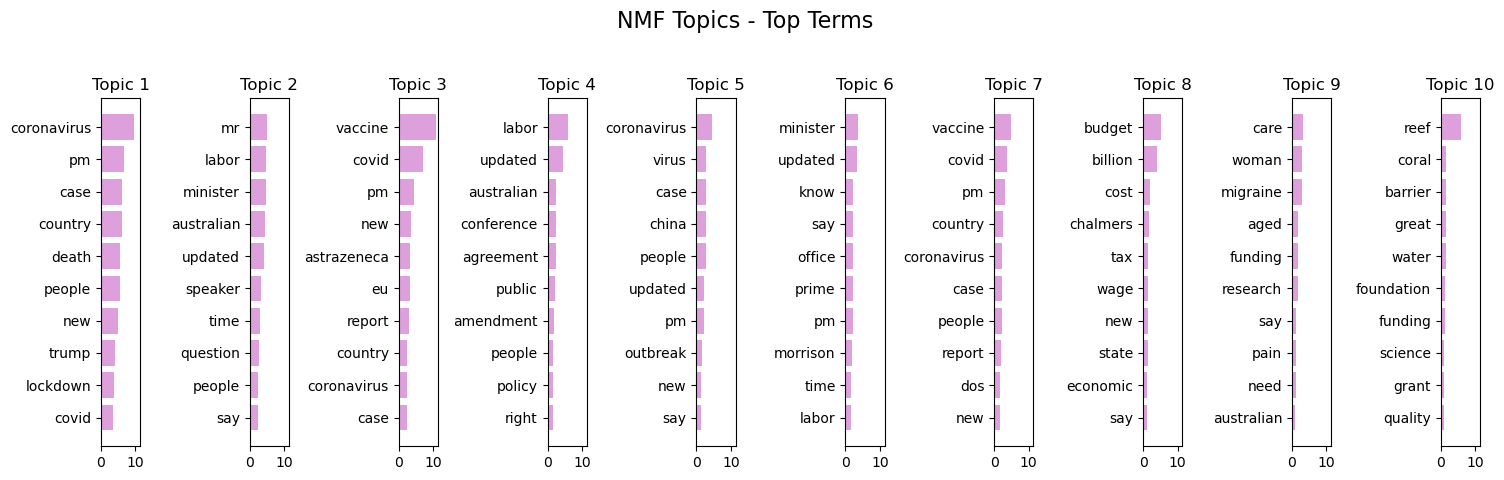

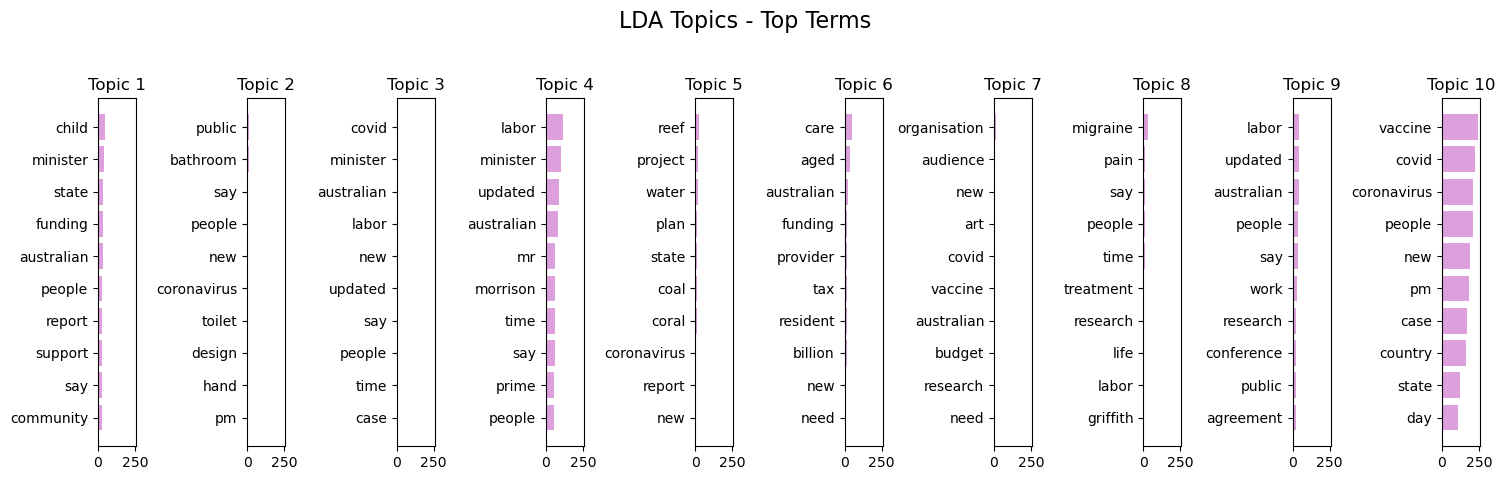

In [27]:
import matplotlib.pyplot as plt

def create_transposed_topic_df(topic_dict):
    topic_data = {}
    for topic, terms in topic_dict.items():
        topic_data[topic] = list(terms.keys())
    df = pd.DataFrame(topic_data)
    df.index = [f'Term {i+1}' for i in range(len(df))]
    return df

def plot_top_terms(topic_dict, title, num_terms=10):
    fig, axes = plt.subplots(1, len(topic_dict), figsize=(15, 5), sharex=True)
    fig.suptitle(title, fontsize=16)
    
    for idx, (topic, terms) in enumerate(topic_dict.items()):
        ax = axes[idx]
        top_terms = list(terms.keys())[:num_terms]
        weights = list(terms.values())[:num_terms]
        ax.barh(top_terms, weights, color='plum')
        ax.set_title(f'Topic {idx+1}')
        ax.invert_yaxis()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
plot_top_terms(nmf_topic_dict, "NMF Topics - Top Terms")
plot_top_terms(lda_topic_dict, "LDA Topics - Top Terms")

The horizontal bar chart visualization for these topic distributions was crafted by combining insights from two sources: ChatGPT and a helpful website https://maartengr.github.io/BERTopic/api/plotting/barchart.html.

**Overview**:

The visualisations show the top terms for each of the 10 topics generated by the NMF and LDA models, highlighting the distinct and common themes identified by each model.

**Comparative Analysis**:

1. **Common Themes**:
   - Both models frequently identify COVID-19 and related public health topics, reflecting the significant impact of the pandemic on news coverage.
   - Economic and budget discussions are consistently prominent in both models, with terms like "budget", "billion", "funding", and "cost" appearing in multiple topics.
   - References to political figures such as "PM", "minister", and "Morrison" appear in both sets of topics, highlighting the coverage of political actions and policies.
2. **Distinct Focuses**:
   - NMF appears to capture more niche topics and specific individuals, such as "chalmers" in economic discussions, "morrison" in political activities and detailed health issues like "migraine".
   - LDA tends to highlight broader themes, including environmental issues (e.g., "reef" and "regulation"). Terms like "child", "community", "support", and "care" highlight a broader consideration of social and community-related issues.
3. **Complementary Insights**:
   - The models complement each other by providing both detailed and broad perspectives on the dataset. NMF's focus on specific terms and individuals helps identify precise themes, while LDA's broader approach captures wider-ranging discussions.

**Conclusion**:

The visualisation of NMF and LDA topics offers a comprehensive understanding of the themes present in the dataset. While both models highlight significant issues like COVID-19 and economic matters, they also provide unique insights that together create a fuller picture of the key topics in the articles. This comparison illustrates the value of using multiple models to analyse text data, ensuring a more robust and nuanced interpretation of the themes.


#### Implications for Health-Related Advancements in Queensland Based on The Guardian's Coverage:

The prevalence of COVID-19-related discussions in both NMF and LDA topics suggests a substantial allocation of resources towards addressing the pandemic's challenges in Queensland. Given the prominence of COVID-19 in public discourse captured by both models, it is reasonable to infer that a significant portion of funding, especially in the health sector, is directed towards managing the impacts of the virus. This allocation reflects the prioritisation of public health emergencies and underscores the importance of robust pandemic response strategies in resource allocation decisions. 

Both economic and budget discussions, as well as political activities and funding issues, appear prominently in both models. These insights highlight significant concerns regarding financial planning and the influence of political decision-making on healthcare policies and resource allocation.

While the analysis provides valuable insights into funding allocation and resource prioritisation, it is crucial to consider the ethical implications of relying solely on algorithmic models like NMF and LDA to inform policy decisions. These models offer data-driven perspectives but may also introduce biases or overlook critical factors that human decision-makers would consider. The models' reliance on text data may inadvertently perpetuate biases present in the underlying dataset, leading to skewed interpretations or recommendations. Additionally, the insights are derived from a specific sample of The Guardian's articles. This sample may not fully represent all relevant discussions and perspectives on health-related advancements in Queensland. Consequently, the findings might not capture the entire scope of public discourse and policy considerations.

Therefore, combining algorithmic insights with human judgment and contextual understanding is essential for making balanced and informed policy decisions. This integrated approach can help mitigate biases, provide a more comprehensive view, and ensure that the decisions made are ethical, fair, and effective.